In [1]:
import numpy as np
import scipy.linalg
import scipy.signal
import scipy.optimize
import networkx as nx
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

from general_graph_utils import *

In [3]:
plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(12,10))
%config InlineBackend.figure_format = 'retina'

In [4]:
def unicycle_graph(n):
    """
    Generates a reversible unicyclic linear framework graph of size n.
    
    Parameters
    ----------
    n : integer
        the size (or number of vertices) of the graph
    
    Returns
    -------
    G : NetworkX DiGraph object
        directed graph
    
    G_ud : NetworkX Graph object
        undirected graph
    """
    
    G = nx.DiGraph()
    G_ud = nx.Graph()
    
    # determine the number of nodes in G
    G_size = n
    
    # add nodes to G and G_ud
    nodes = np.arange(1,G_size+1,step=1)
    G.add_nodes_from(nodes)
    G_ud.add_nodes_from(nodes)
    
    for i in range(2,G_size+1):
        u = i-1
        v = i
        G.add_edge(u,v)
        G.add_edge(v,u)
        G_ud.add_edge(u,v)
        
    G.add_edge(G_size,1)
    G.add_edge(1,G_size)
    G_ud.add_edge(1,G_size)
    
    return G, G_ud

In [5]:
# Function to compute the correlation function C(t)
def correlation_function_general(t, W, n):
    exp_Wt = scipy.linalg.expm(W * t) # Compute the matrix exponential e^(Wt)
    #p = np.zeros((1,n))
    #p[0] = 1
    #return (exp_Wt[0]*p)[0] # e^(Wt)[11] Prob of being in 1 at time t given was in 1 at time 0
    return exp_Wt[0][0]

In [6]:
N = 40
G, G_ud = unicycle_graph(N)

In [7]:
node_list = get_nodes(G)
num_nodes = len(node_list)
edge_list = get_edges(G)

cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

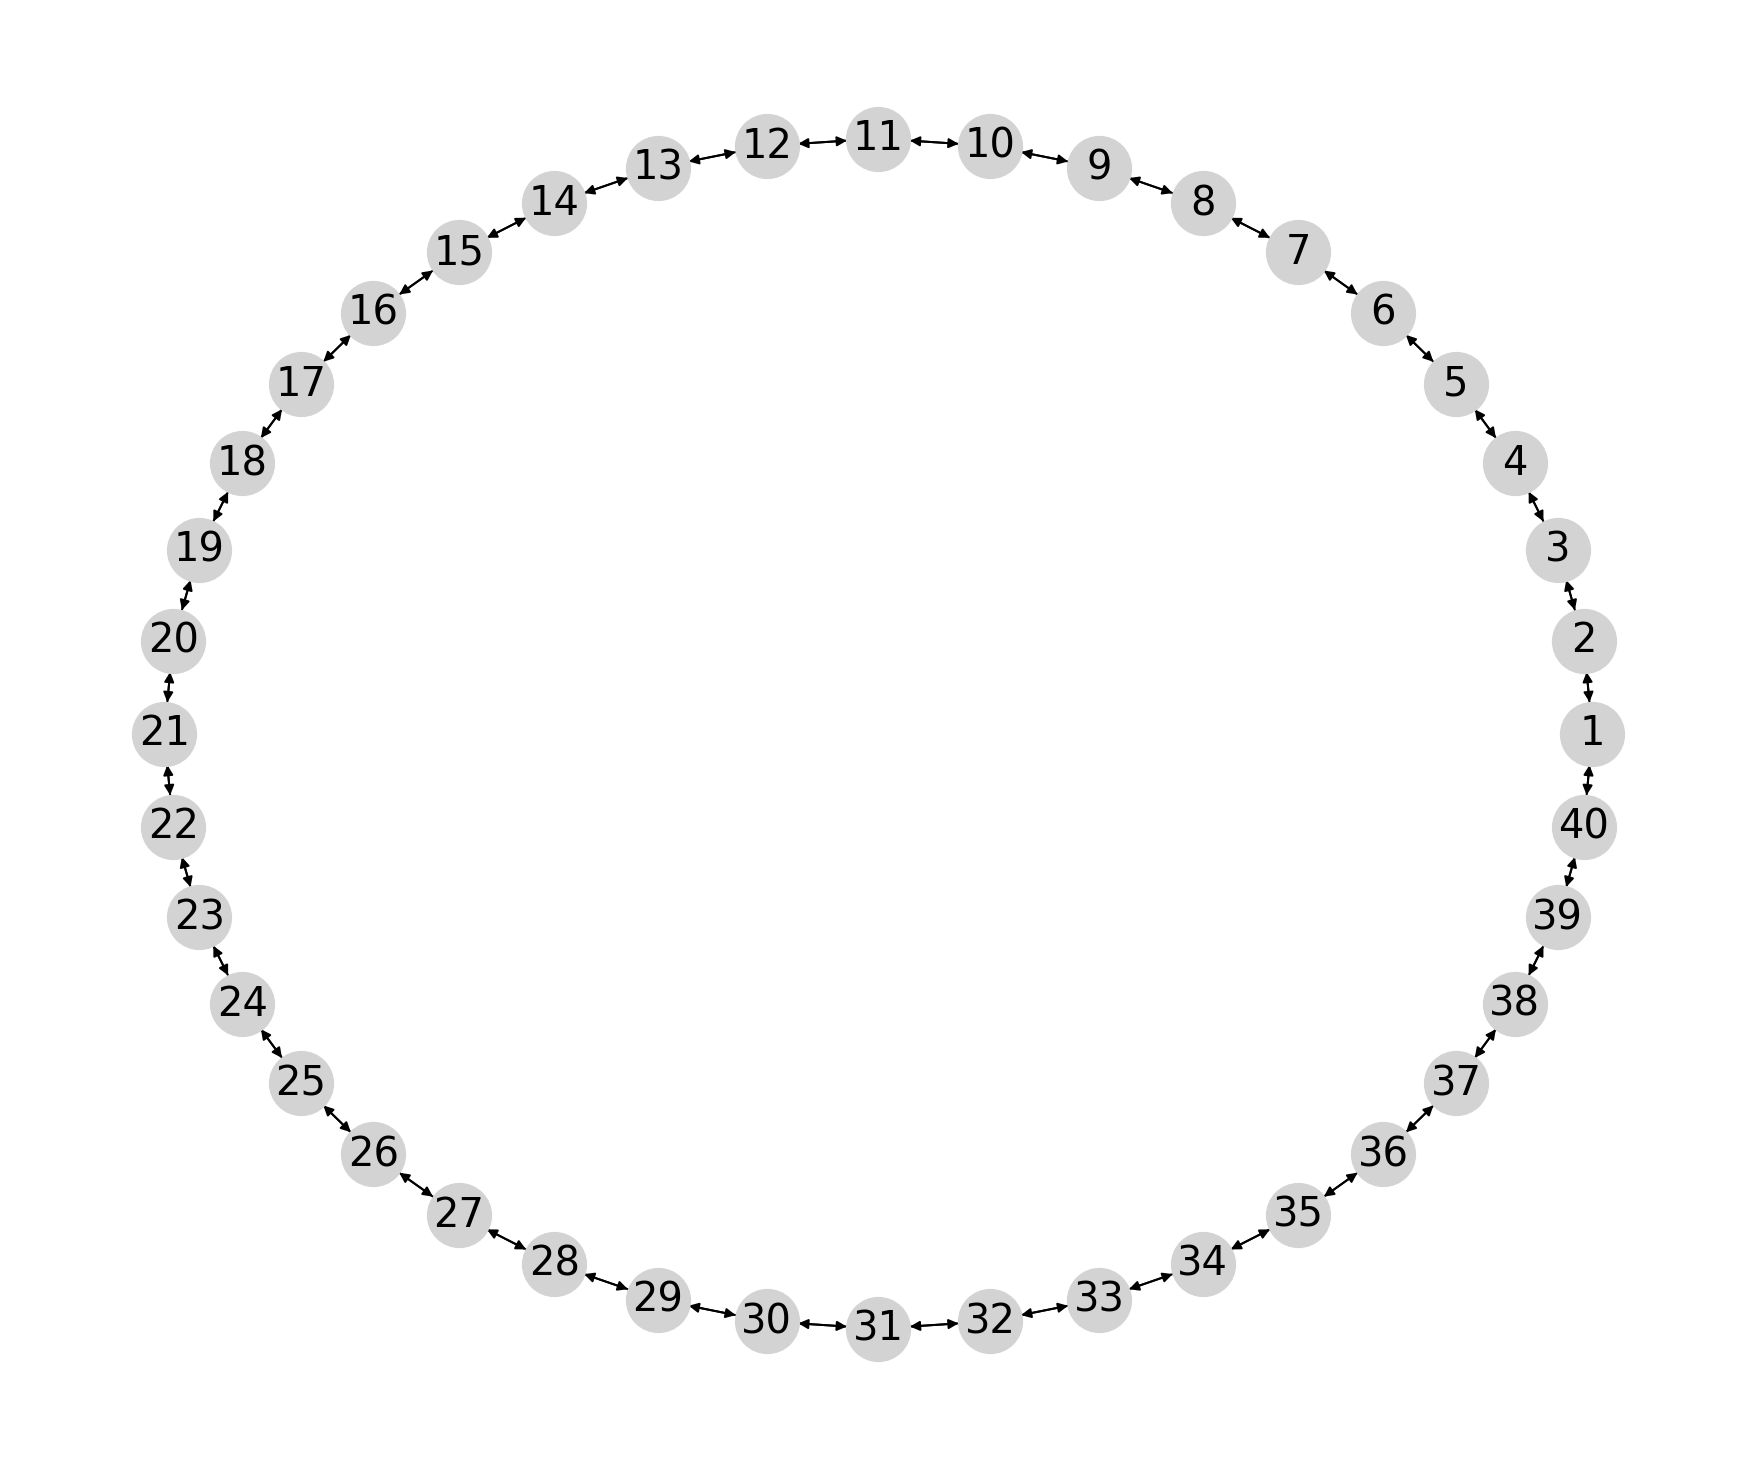

In [8]:
node_labels = {}

for node in node_list:
    node_labels[node] = str(node)

nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=1000, node_color = 'lightgray', font_size=20, font_color='black', font_family='sans-serif')

In [9]:
# parameter values from Barato Seifert 2017
k_m = 1.0
A = 200
k_p = k_m*np.exp(A/N)

In [10]:
edge_labels_forward = np.array([])
edge_labels_backward = np.array([])

for i in range(num_nodes-1):
    u = cycle_list[0][i]
    v = cycle_list[0][i+1]
    
    G[u][v]['weight'] = k_p
    edge_labels_forward = np.append(edge_labels_forward, k_p)
    
    G[v][u]['weight'] = k_m
    edge_labels_backward = np.append(edge_labels_backward, k_m)

G[cycle_list[0][-1]][cycle_list[0][0]]['weight'] = k_p
edge_labels_forward = np.append(edge_labels_forward, k_p)
G[cycle_list[0][0]][cycle_list[0][-1]]['weight'] = k_m
edge_labels_backward = np.append(edge_labels_backward, k_m)

In [11]:
label_dict = {e: G[e[0]][e[1]]['weight'] for e in G.edges}

In [12]:
label_list = np.fromiter(label_dict.values(), dtype=float)

In [13]:
W = Laplacian_all(edge_list,label_list,node_list)

In [14]:
affinity = np.log(np.prod(edge_labels_forward)/np.prod(edge_labels_backward))
affinity

200.0

In [ ]:
# eigenvalues of W
W = Laplacian_all(edge_list,label_list,node_list)
eigvals, eigvecs = scipy.linalg.eig(W)

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

print(x_i, x_r)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0.1, 5, 500)  # time from 0 to 1.5 with 500 pts
# Compute C(t) for each time point
correlation_values = [correlation_function_general(t, W, n=40) for t in tqdm(times)]

23.06049868410202 1.8395248228988317
decay time: 0.5436186495293611
period: 0.27246528330765174
number coherent oscillations: 19.691686774828682


 31%|████████████▋                            | 155/500 [00:19<00:46,  7.46it/s]

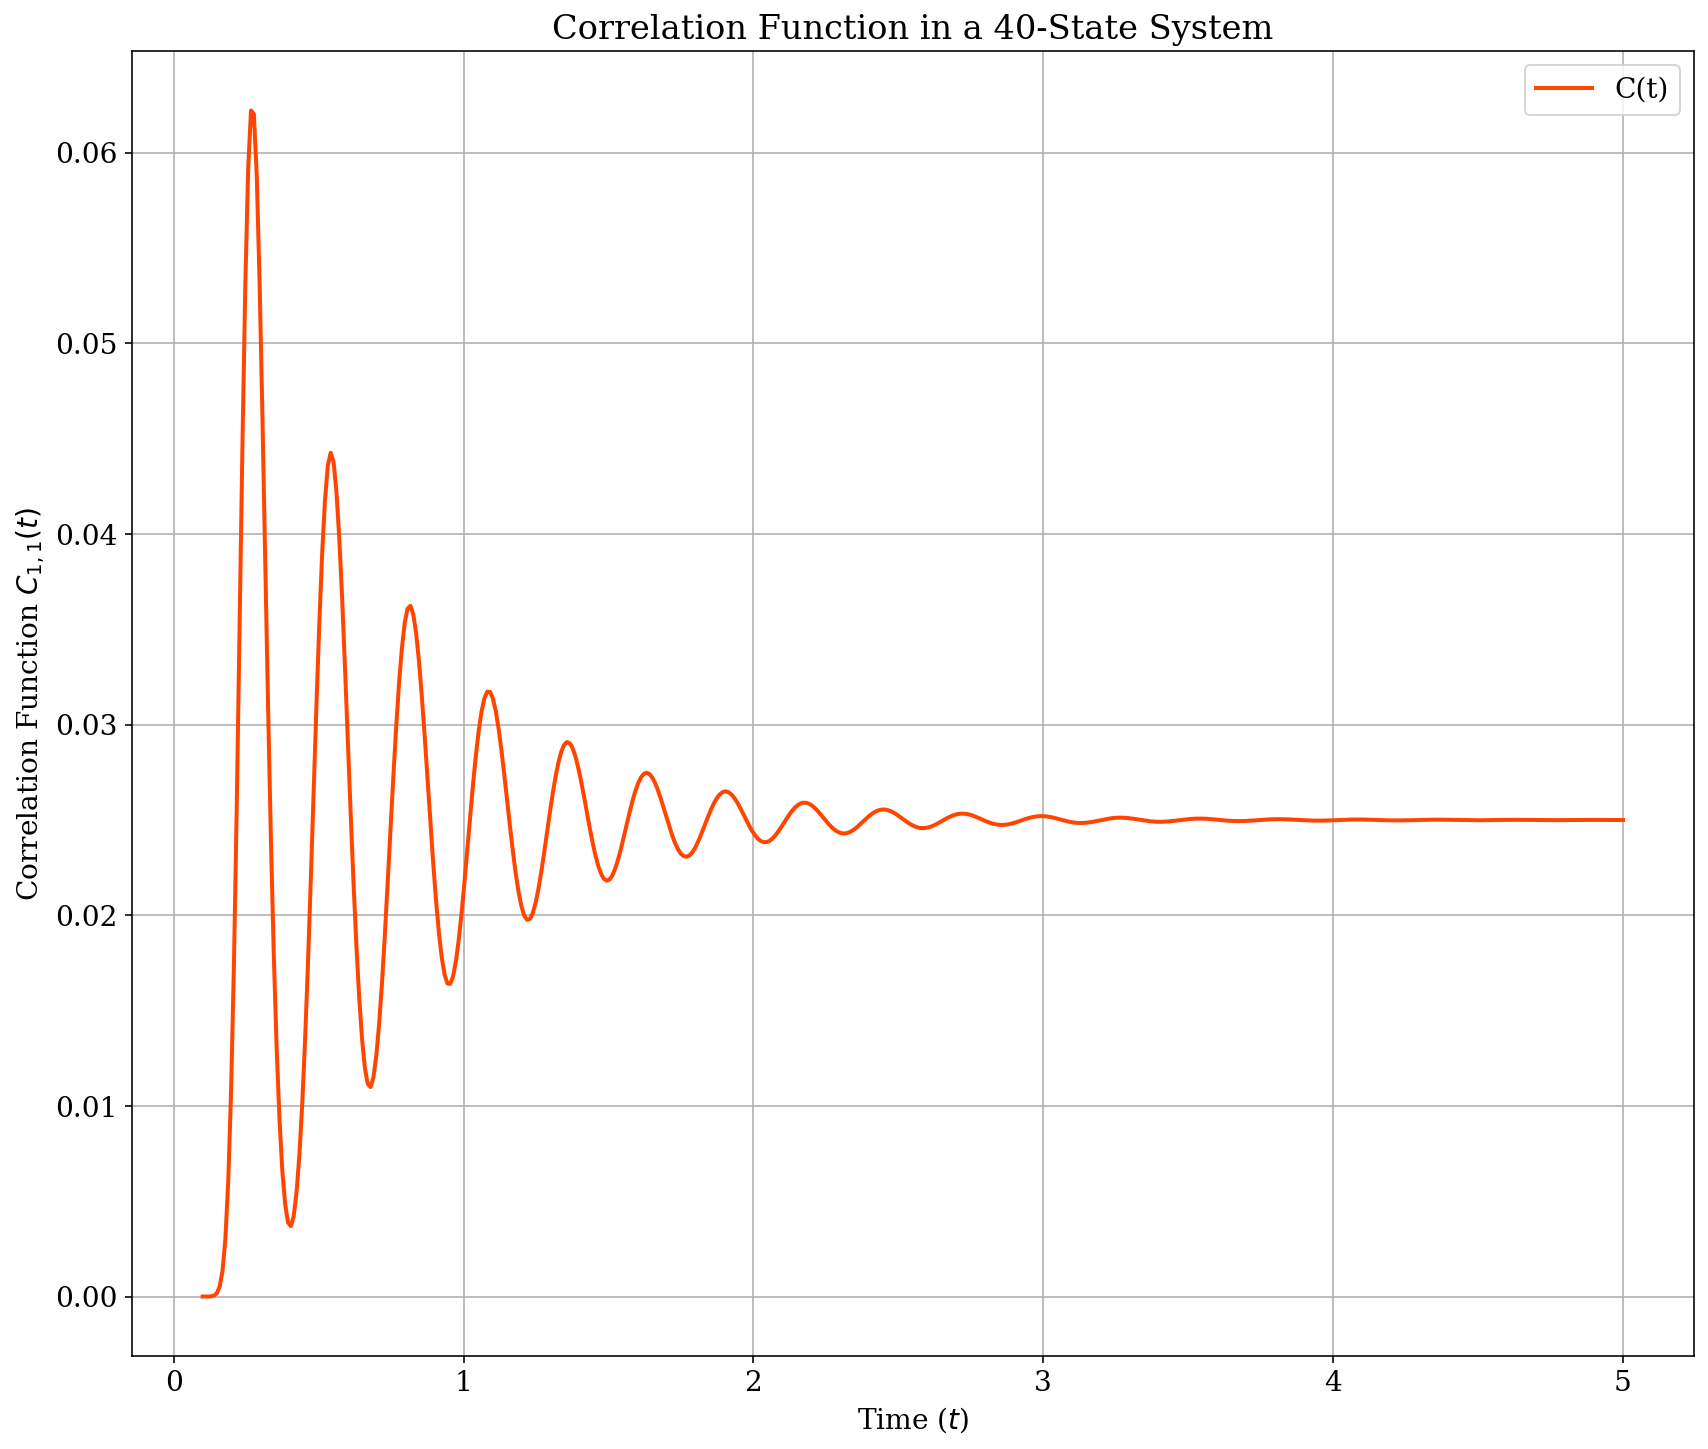

In [15]:
num_states = str(N)
fig, ax = plt.subplots(figsize = (14, 12))
plt.plot(times, correlation_values, color = "orangered", linewidth=2, label='C(t)')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Correlation Function in a '+ num_states +'-State System')
plt.legend()
plt.grid()
plt.show()

In [16]:
def gillespie_unicyclic(N, F_init, T_max):
    """
    Simulates a unicyclic chemical reaction network using the Gillespie algorithm.
    
    Parameters:
    N      : int   - Number of states in the cycle
    F_init : float - Initial thermodynamic force
    T_max  : float - Maximum simulation time
    
    Returns:
    times  : list of floats - Time points of state transitions
    states : list of ints   - States visited over time
    """
    # Initialize system state
    state = 0  # Start at state 0
    time = 0.0  # Initialize time
    F = F_init  # Initial thermodynamic force
    
    # Store trajectory
    times = [time]
    states = [state]
    
    while time < T_max:
        # Compute reverse rates dynamically
        k_minus = np.exp(-F / N)
        
        # Compute propensities
        a_plus = 1      # Forward rate
        a_minus = k_minus  # Reverse rate
        
        # Total rate
        a_total = a_plus + a_minus
        
        # Generate time step from exponential distribution
        tau = -np.log(np.random.rand()) / a_total
        time += tau
        
        if time > T_max:
            break
        
        # Determine which reaction occurs
        if np.random.rand() < a_plus / a_total:
            state = (state + 1) % N  # Forward move
        else:
            state = (state - 1) % N  # Reverse move
        
        # Update thermodynamic force dynamically in logarithmic steps
        F *= 1.01  # Modify as needed
        
        # Store results
        times.append(time)
        states.append(state)
    
    return times, states

In [19]:
def plot_trajectory(times, states):
    """
    Plots the state trajectory over time.
    """
    fig, ax = plt.subplots(figsize = (14, 12))
    plt.step(times, states, where='post', label='State Trajectory', linewidth = 2, color='deeppink')
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.title('Gillespie Simulation of 40-State Unicyclic Network')
    plt.legend()
    plt.grid()
    plt.show()

In [18]:
# Example usage
N = 40         # Number of states in cycle
F_init = 200  # Initial thermodynamic force
T_max = 100   # Maximum simulation time
times, states = gillespie_unicyclic(N, F_init, T_max)

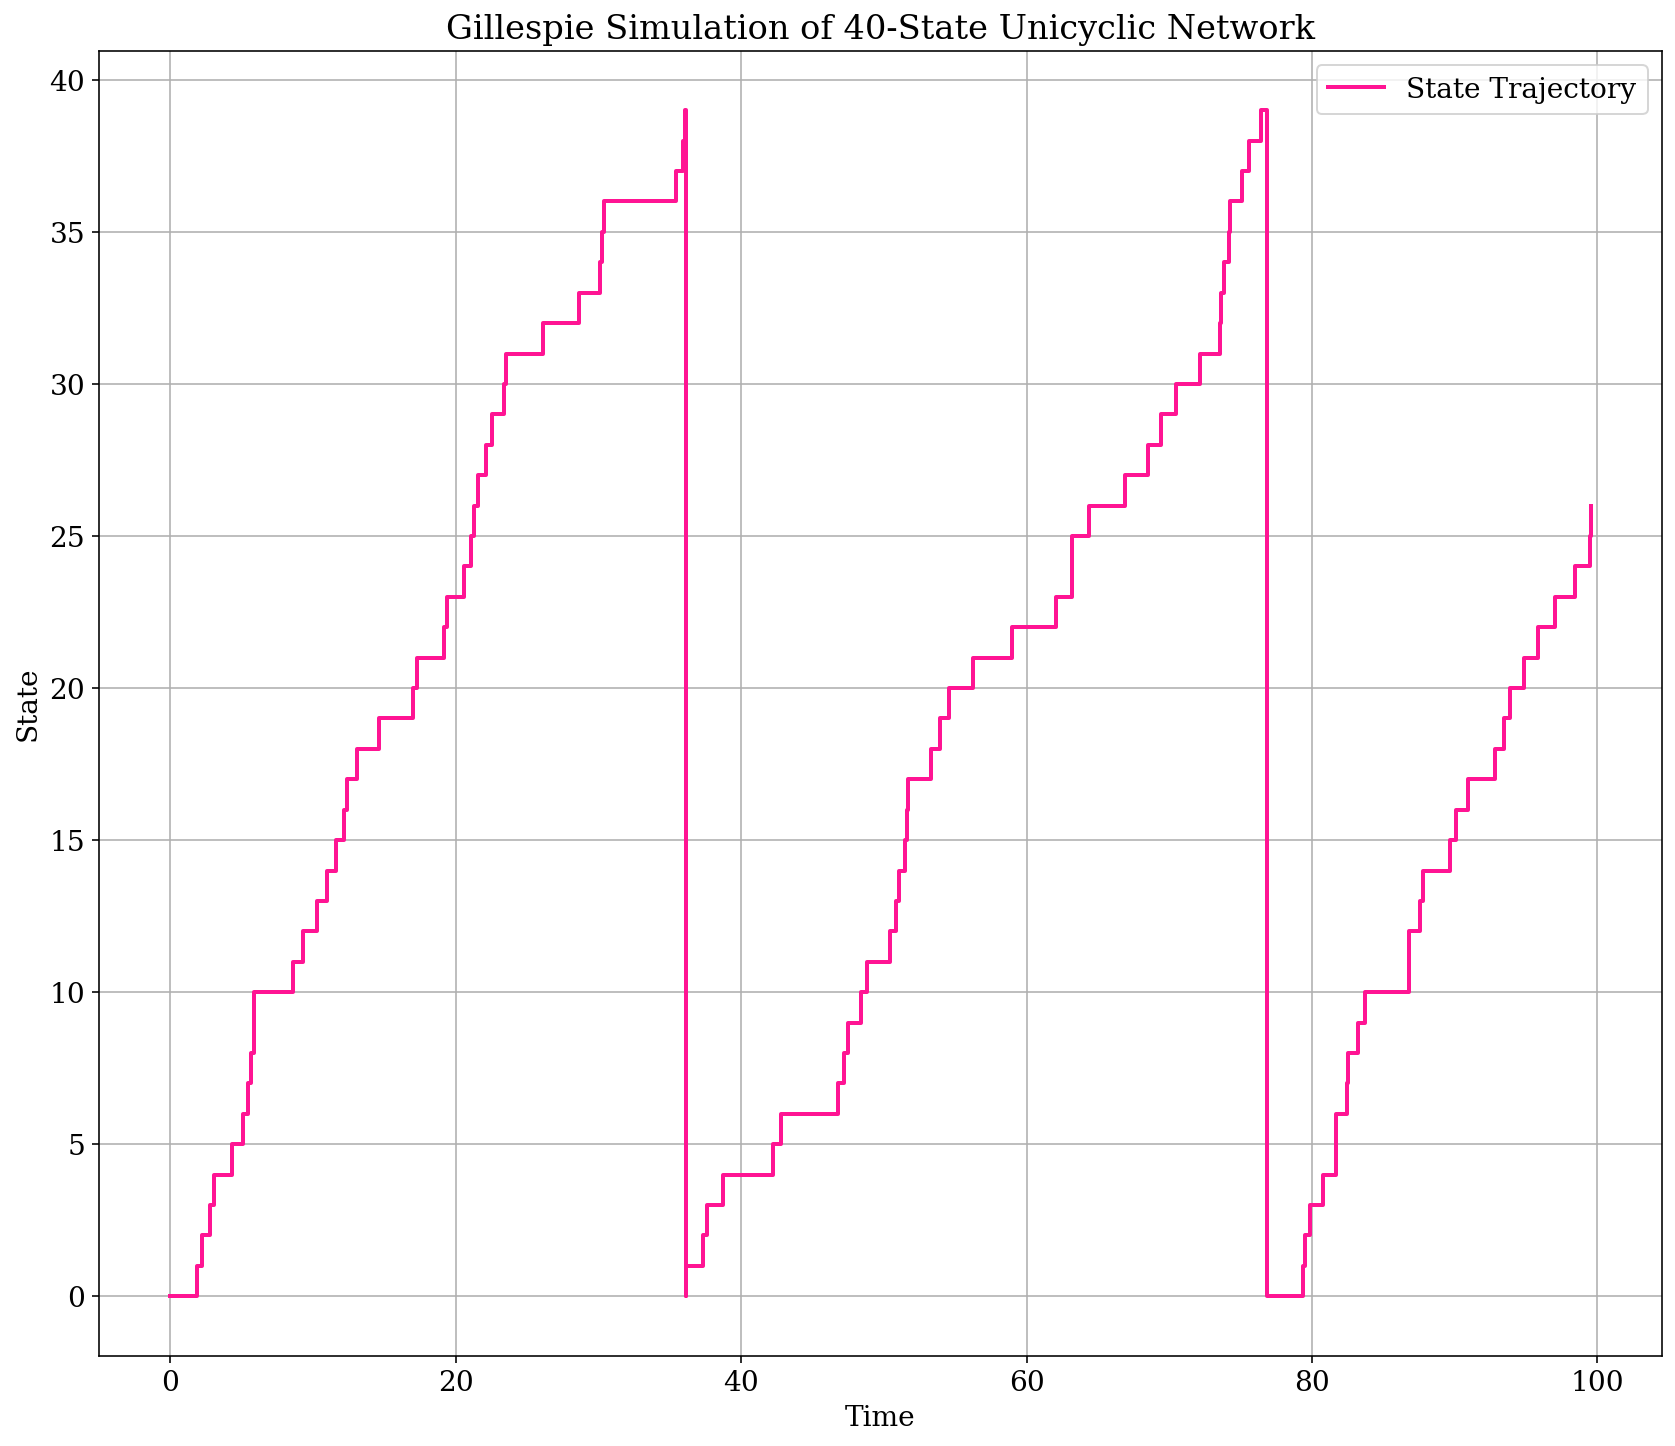

In [20]:
plot_trajectory(times, states)